In [40]:
import sys
sys.path.insert(0, '../src/data')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
import bame_datastore
bame_datastore.lib

Found local clean copy of ethnicity_2011
Found local clean copy of Local_Authority_Districts__December_2009__Boundaries
Found local clean copy of fbook_covid_deaths
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of furlough_data
Found local clean copy of key_workers


{'mortality': ['fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers'],
 'other': ['lad_geog']}

In [3]:
#clean ons deaths
df  = bame_datastore.ons_deaths.df
df = df.drop("Isles of Scilly", )
df = df.replace(r':', np.nan, regex=True)
df['all_Rate'] = df['all_Rate'].astype('float64')
df['covid_Rate'] = df['covid_Rate'].astype('float64')
df = df[['all_Deaths', 'all_Rate', 'covid_Deaths', 'covid_Rate']]

In [4]:
# Create total share of non-white ethnicity by region
eth_df = bame_datastore.ethnicity_data.df.copy()
bame_cols = eth_df.columns[2:20] #collection of non-white ethnicities 
eth_df['bame_share'] = eth_df[bame_cols].sum(axis=1)
eth_df.drop(columns = bame_cols, inplace=True)
eth_df.drop(columns = eth_df.columns[2:7], inplace=True)

In [5]:
df  = df.join(eth_df) #deaths and ethnicity
df  = df.join(bame_datastore.furlough_data.df) # join furlough data
df  = df.join(bame_datastore.key_workers.df) #join key workers

In [6]:
# add the geography
gdf = bame_datastore.lad_geog.gdf.set_index("lad09nm")
gdf = gdf.join(df)

# Visualisation

In [7]:
def plot_map(gdf, col_name):
    f, ax = plt.subplots(1, figsize=(9, 9))
    gdf.plot(ax=ax, column=col_name, legend=True, missing_kwds= dict(color = "lightgrey",))
    ax.set_axis_off()
    ax.set_title(col_name)
    plt.axis('equal')
    plt.show()

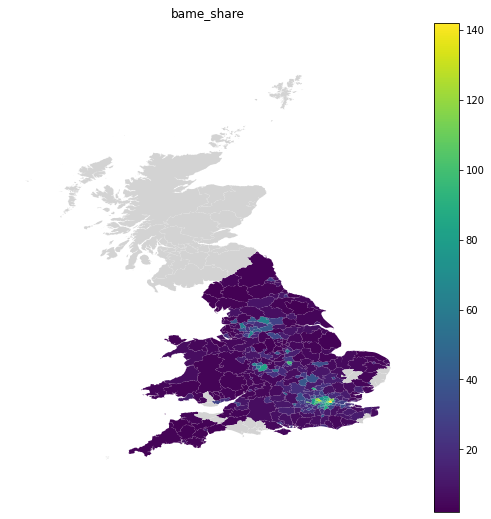

In [8]:
plot_map(gdf, 'bame_share')

Text(0.5, 1.0, 'Non Population Standardised')

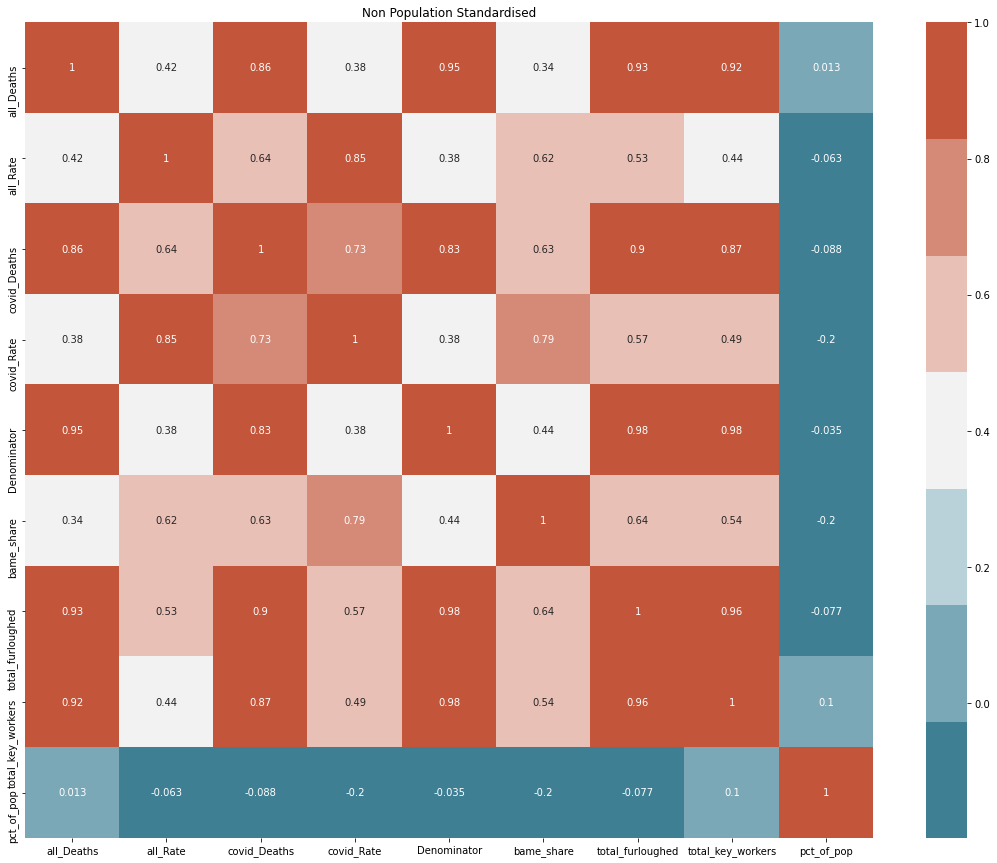

In [19]:
# correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = gdf[gdf.columns[5:]].corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.title("Non Population Standardised")
# plt.show()
# plt.savefig("../reports/figures/corrmat.png")

The high correlations probably due to population effects. So now control for population. 

In [28]:
gdf_norm = gdf.copy()
gdf_norm["pct_furloughed"] = gdf_norm["total_furloughed"]/gdf_norm["Denominator"]
col_dict = {'all_Rate':'all_death_rate', 'covid_Rate':'covid_death_rate',
'Denominator':'population', 'bame_share':'bame_share',
       'pct_furloughed':'pct_furloughed', 'pct_of_pop':'key_workers_pct',}
gdf_norm = gdf_norm.rename(columns=col_dict)
gdf_norm = gdf_norm[col_dict.values()]

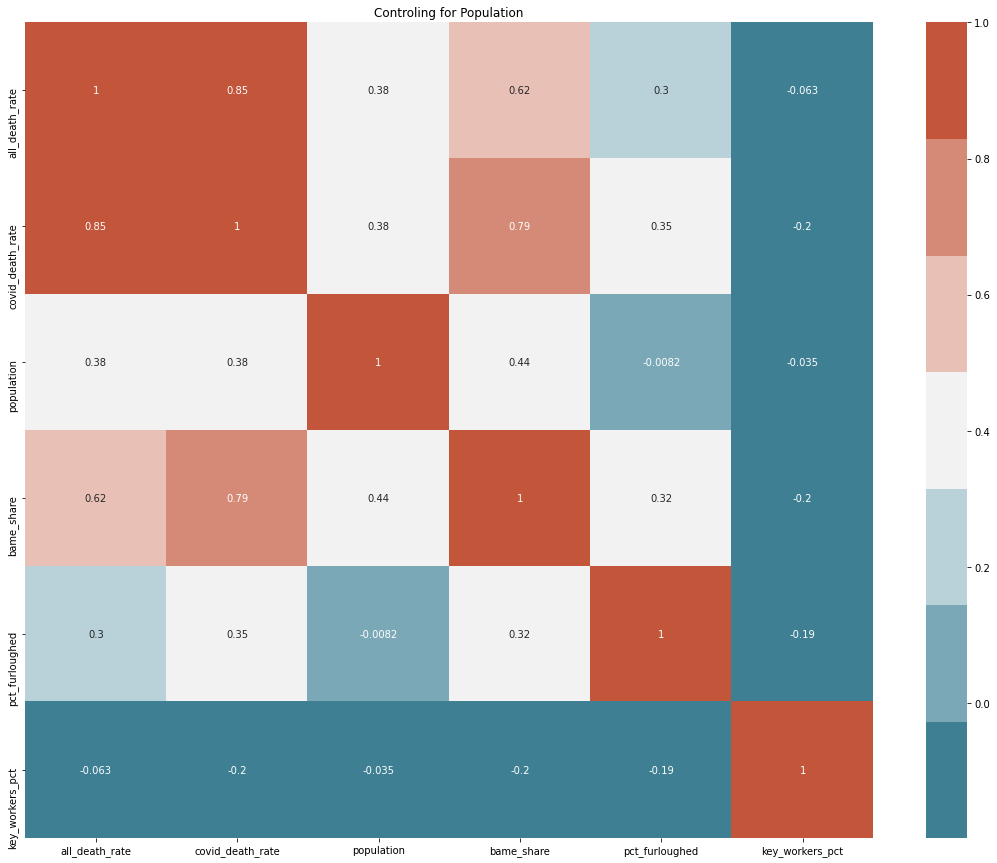

In [62]:
# correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = gdf_norm.corr()
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.title("Controling for Population")
plt.savefig("../reports/figures/standardised_explain.png")

# Causal Nex

https://causalnex.readthedocs.io/en/latest/03_tutorial/03_tutorial.html

/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/causalnex/structure/notears.py:391: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/causalnex/structure/notears.py:407: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/causalnex/structure/notears.py:437: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")
/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/pygr

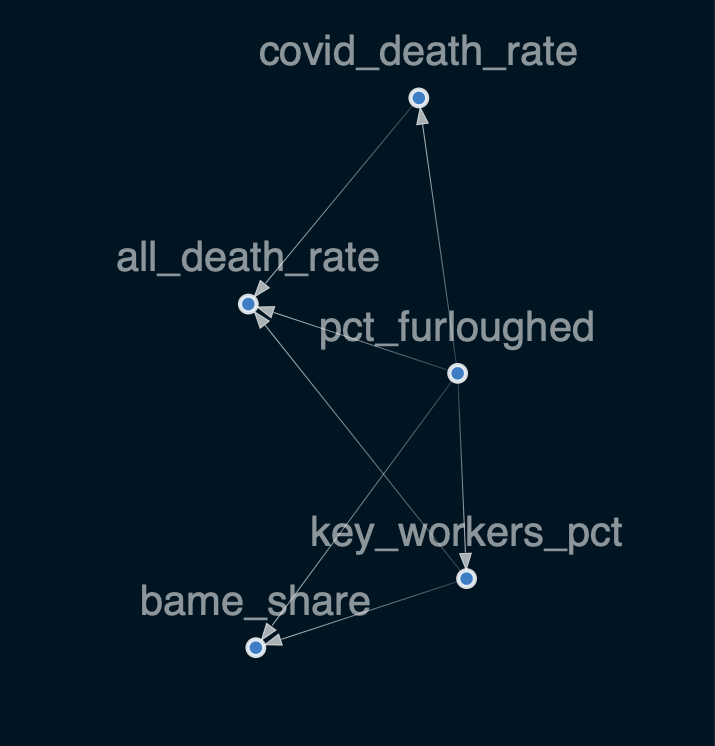

In [65]:
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image


nex_df = gdf_norm.copy().dropna()
nex_df.drop(columns=["population"], inplace=True)
nex_df.to_csv("../data/processed/explain_pop_norm.csv")

sm = from_pandas(nex_df, tabu_edges=[("covid_death_rate", "bame_share")])
sm.remove_edges_below_threshold(0.8)


viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.9"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))
